Linear regression with various regularizers 
The UCI Machine Learning dataset repository hosts a dataset giving features of music, and the latitude and longitude from which that music originates here. Investigate methods to predict latitude and longitude from these features, as below. There are actually two versions of this dataset. Either one is OK by me, but I think you'll find the one with more independent variables more interesting. You should ignore outliers (by this I mean you should ignore the whole question; do not try to deal with them). You should regard latitude and longitude as entirely independent.

First, build a straightforward linear regression of latitude (resp. longitude) against features. What is the R-squared? Plot a graph evaluating each regression.

Does a Box-Cox transformation improve the regressions? Notice that the dependent variable has some negative values, which Box-Cox doesn't like. You can deal with this by remembering that these are angles, so you get to choose the origin. why do you say so? For the rest of the exercise, use the transformation if it does improve things, otherwise, use the raw data.

Use glmnet to produce:
A regression regularized by L2 (equivalently, a ridge regression). You should estimate the regularization coefficient that produces the minimum error. Is the regularized regression better than the unregularized regression?
A regression regularized by L1 (equivalently, a lasso regression). You should estimate the regularization coefficient that produces the minimum error. How many variables are used by this regression? Is the regularized regression better than the unregularized regression?

In [1]:
# install.packages('glmnet', repos='http://cran.us.r-project.org', dependencies=TRUE)
library(glmnet)
library(lattice)
library(MASS)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



In [2]:
# reads in the data set
wdata = read.csv('music_data_less.txt', header = FALSE)
wdata = na.omit(wdata)
# separatesthe latitude and longitude
# 69 refers to latitude
# 70 refers to longitude
lat = wdata[69]
lon = wdata[70]
features = wdata[1:68]
# grabs the features
# 69 refers to latitude
# 70 refers to longitude
features_with_lat = wdata[1:69]
features_with_lon = wdata[1:70]
features_with_lon$V69 = NULL 

In [3]:
fit_lat = lm(features_with_lat$V69 ~ ., data=features_with_lat)
# summary(fit_lat)

In [4]:
# plot(fit_lat)

In [5]:
fit_lon = lm(features_with_lon$V70 ~ ., data=features_with_lon)
# summary(fit_lon)

In [6]:
# plot(fit_lon)

In [25]:
# Create a modified Dataframe with all of the degrees (lat + lon) shifted such that there is no negative values.
# We shift by 180 to make all the value 
# 69 refers to latitude
# 70 refers to longitude
mod_df = wdata[69:70] + 90

[1] "Optimal Lambda (latitude): "


[1] 3.636364

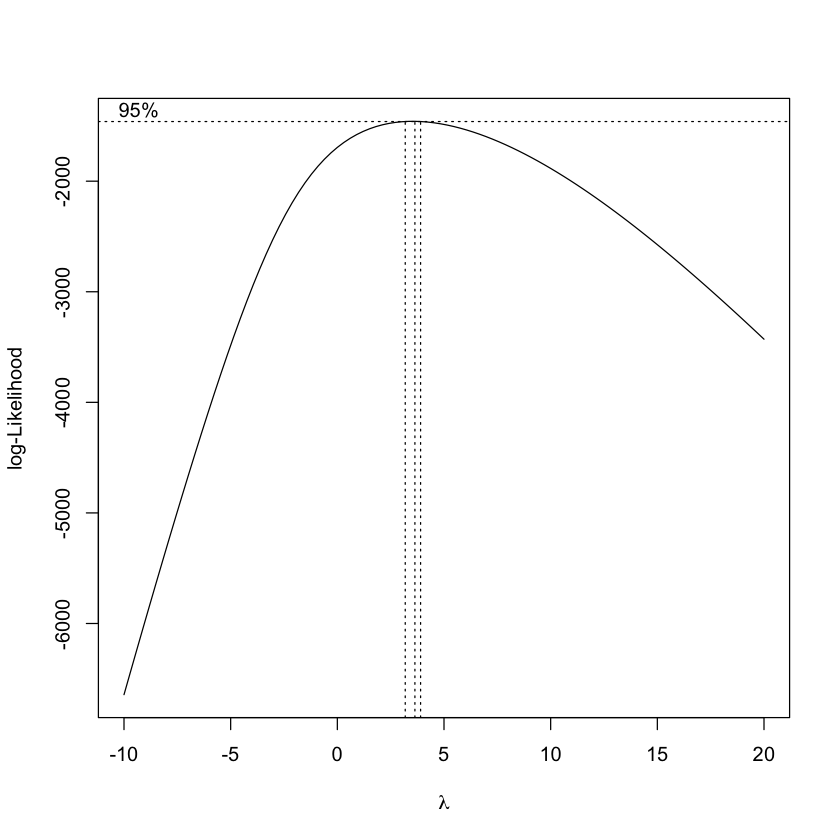

In [30]:
# Apply Box-Cox to find the optimal value of lambda.
lat_eq = lm(mod_df$V69 ~ ., data=features)

val = boxcox(lat_eq, lambda=seq(-10, 20, by=0.5))
trans_df = as.data.frame(val)
optimal_lambda = trans_df[which.max(val$y),1]
print('Optimal Lambda (latitude): ')
lat_lambda = optimal_lambda
lat_lambda

[1] "Optimal Lambda (longitude): "


[1] 0.9090909

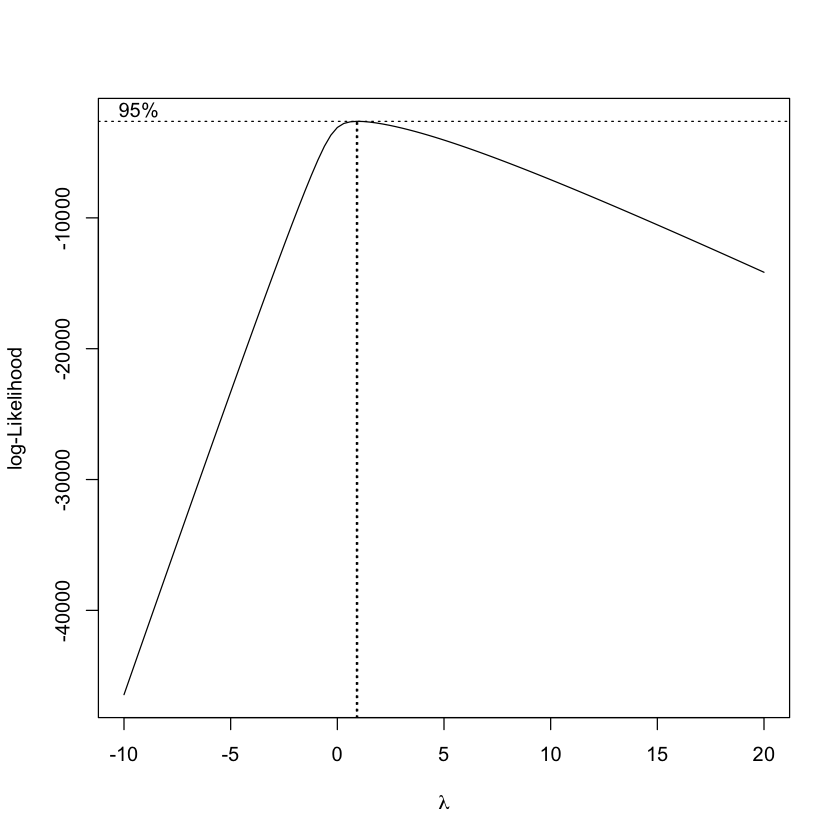

In [31]:
lon_eq = lm(mod_df$V70 ~ ., data=features)
val = boxcox(lon_eq, lambda=seq(-10, 20, by=0.5))
trans_df = as.data.frame(val)
optimal_lambda = trans_df[which.max(val$y),1]
print('Optimal Lambda (longitude): ')
lon_lambda = optimal_lambda
lon_lambda